# Analyzing a Fortran Stencil Program

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Understanding

Open the <tt>stencil2d-orig.F90</tt> Fortran program by double clicking on the file in the File Browser on the left (if it is hidden, click on the Folder icon).

![open-stencil2d](img/open-stencil2d.png)

If you prefer, you can also open a new Terminal (File -> New -> Terminal), navigate to the location where <tt>stencil2d-orig.F90</tt> is located and use your favorite linux editor (e.g. vim) to browse the Fortran source code. This will give you better syntax highlighting.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>1.</b> Read the code of <tt>stencil2d-orig.F90</tt> and understand what the program is doing. If you are new to Fortran programming, take a look <a href="https://ourcodingclub.github.io/tutorials/fortran-intro/">here</a> for a brief introduction.<br>
<b>2.</b> Compile the code and run it (see below).<br><br>

<i>Note 1:</i> The code in cells which start with the <code>%%bash</code> command are not Python code. They contain commands that you would otherwise type into a terminal. If you are unfamiliar with this, give it a try! Create a new cell which starts with <code>%%bash</code> and put a linux command in the cell (e.g. <code>ls</code>). This is very convenient for executing shell commands in a Python notebook. If you want to read more about this, take a look at the <a href="https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-script">documentation</a> (note that <code>%%bash</code> is a shorthand for <code>%%script bash</code>).<br><br>
<i>Note 2:</i> The <tt>make</tt> command is a standard linux tool that eases the burden of compiling a program. It relies on a <tt>Makefile</tt> which contains instructions of how to build a <i>target</i>. Our <tt>Makefile</tt> is written in a way that we can conveniently compile multiple versions of the <tt>stencil2d-</tt><i>version</i><tt>.F90</tt> program. The standard output of the cell shows which commands are actually executed to compile our program. The actual compilation is of the form <code>ftn <i>[-option] name</i>.F90</code>.<br>
</div>

## Compiling

On Piz Daint, the programming environment is managed using so called modules. We need to load the right modules in order to compile our program. We are going to use the Cray Fortran compiler (<tt>PrgEnv-cray</tt>) for this exercise. (Note: If we are using <tt>%%bash</tt> cell magic, these commands need to be repeated every time to setup the right environment.

In [2]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

echo "===== cleaning up ====="
make clean
echo "===== compiling ====="
make VERSION=orig

===== cleaning up =====
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
===== compiling =====
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-orig.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-orig.o -o stencil2d-orig.x
cp stencil2d-orig.x stencil2d.x


INFO: creating the CrayPat-instrumented executable 'stencil2d-orig.x' (lite-samples) ...OK


## Running

We can run our program on all 12 cores of the Xeon E5-2690 v3 Haswell CPU that we have available using the <tt>srun</tt> command. The command line arguments <tt>nx, ny, nz</tt> specify the size of the computational domain and <tt>num_iter</tt> sets the number of iterations (timesteps).

In [3]:
%%bash --out stdout
srun -n 12 ./stencil2d-orig.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

The result of the `%%bash` magic is stored as a string in the `stdout` variable. We can examine the result. Since the output of the Fortran program is already in a format that is understandable by Python, we can also execute the code contained in the string to define `data`.

In [4]:
print(stdout)
exec(stdout)

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,    1024,  0.1177043E+02], \
] )



We now have the output of the `stencil2d-orig.F90` program in a data structure named `data` in our notebook. As you can see above, it contains the number of cores we ran on `ranks` (12), `nx` (128), `ny` (128), `nz` (64), the number of iterations `num_iter` (1024) and the actual runtime in seconds (approx. 10 s).

In [5]:
print(data)

[[  12.       128.       128.        64.      1024.        11.77043]]


The Fortran program writes two data files (`in_field.dat` and `out_field.dat`) which contain the initial condition as well as the resulting field at the end of the iterations. We can load the data into Python in order to visually verify that our stencil program is actually applying diffusion. We show only the lowest level (`k=0`) in the images.

In [6]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset=(3 + rank) * 32 // nbits
    data = np.fromfile(filename, dtype=np.float32 if nbits == 32 else np.float64, \
                       count=nz * ny * nx + offset)
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))

def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file('in_field.dat')
    k_lev = in_field.shape[0] // 2
    im1 = axs[0].imshow(in_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im1, ax=axs[0]);
    axs[0].set_title('Initial condition (k = {})'.format(k_lev));

    out_field = read_field_from_file('out_field.dat')
    k_lev = out_field.shape[0] // 2
    im2 = axs[1].imshow(out_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im2, ax=axs[1]);
    axs[1].set_title('Final result (k = {})'.format(k_lev));
    
    plt.show()

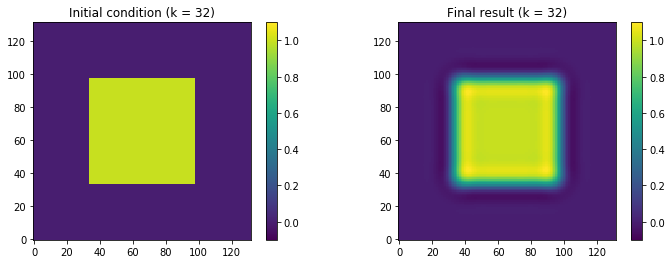

In [7]:
validate_results()

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>3.</b> Play around a bit with the above program. Change the number of iterations to 1 and run again and make a visualization of the result after only 1 iteration. Change back to 1024 iterations and change the size of the domain to <tt>nx=ny=64</tt> and give it a spin. How does the runtime change when you reduce the computational domain by a factor of 4x? Feel free to explore more and get comportable with the Fortran program...<br>
<b>4.</b> There is another version of the stencil program named <tt>stencil2d-counters.F90</tt> where we have introduced two global variables of type <tt>integer</tt> named <tt>flop_counter</tt> and <tt>byte_counter</tt>. The goal of this exercise is to manually count the number of floating point operations and amount of memory transfers directly in the code inside the loops where the work is happening. Edit the program to count the number of floating-point operations and bytes transferred to/from memory. Compile and run. <i>(Hint: The places where you need to make edits are marked with TODO in the code and a first example is given.)</i><br>
<b>5.</b>Compile and run the <tt>stencil2d-counters.F90</tt> program. The flop and byte count will appear in the standard output as additional entries into the <tt>data</tt> array. Make sure that the runtime is still approximately the same as before and that the introduction of the counters did not impact the runtime too negatively. Also validate the program is still correct by visualizing the results using <tt>validate_results()</tt>.<br>
</div>

In [8]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=counters

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-counters.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-counters.o -o stencil2d-counters.x
cp stencil2d-counters.x stencil2d.x


INFO: creating the CrayPat-instrumented executable 'stencil2d-counters.x' (lite-samples) ...OK


In [9]:
%%bash --out stdout
srun -n 12 ./stencil2d-counters.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

In [10]:
print(stdout)
exec(stdout)
print(data)

# ranks nx ny ny nz num_iter time flop byte
data = np.array( [ \
[   12,  128,  128,   64,    1024,  0.1230024E+02,  0.2781477E+11,  0.2739563E+12], \
] )

[[1.200000e+01 1.280000e+02 1.280000e+02 6.400000e+01 1.024000e+03
  1.230024e+01 2.781477e+10 2.739563e+11]]


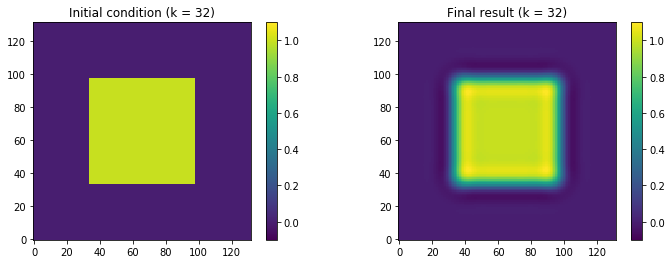

In [11]:
validate_results()

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>6.</b> Using the flop and byte counts stored in <tt>data</tt>, compute the arithmetic intensity $I$ of our stencil program.<br>
<b>7.</b> Compute the performance in GFLOP/s of our stencil program. Is our program memory bound or compute bound? Which % of peak FLOP/s and memory bandwidth do we achieve? Do you trust these estimations?<br>
</div>

In [12]:
gflop_counter = data[0, 6] / 1024. / 1024. / 1024. # TODO
gb_counter = data[0, 7] / 1024. / 1024. / 1024. # TODO
arithmetic_intensity = gflop_counter / gb_counter # TODO
print("Arithmetic intensity = {}".format(arithmetic_intensity))

Arithmetic intensity = 0.10152995203979613


In [13]:
runtime = data[0, 5] # TODO
peak_bandwidth_in_gbs = 63.5683536529541 # TODO
peak_performance_in_gflops = 249.69600000000003 # TODO
performance_in_gflops = gflop_counter / runtime # TODO
bandwidth_in_gbs = gb_counter / runtime # TODO
performance_percent_peak = performance_in_gflops / peak_performance_in_gflops * 100. # TODO
bandwidth_percent_peak = bandwidth_in_gbs / peak_bandwidth_in_gbs * 100. # TODO
print("GFLOP/s = {} ({:6.3f}% theoretical peak)    GB/s = {} ({:6.3f}% theoretical peak)".format( \
    performance_in_gflops, performance_percent_peak, bandwidth_in_gbs, bandwidth_percent_peak))

GFLOP/s = 2.1060177044299437 ( 0.843% theoretical peak)    GB/s = 20.742821818771862 (32.631% theoretical peak)


<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>8.</b> Run the stencil program for different <tt>nx</tt> and <tt>ny</tt> (using the <tt>--scan</tt> option, see below). Import the data into a Python notebook and make a loglog-plot of the runtime per gridpoint $r = \mathrm{runtime} \, / \, nx \, / \, ny \, / nz$ in $\mu s$ versus the working set size $\mathrm{work\_size} = nx \times ny \times nz \times 3 \times 4 \, \mathrm{Bytes}$ in MB. How would you expect this plot to look like for a von Neumann architecture? What might be the reason that the behavior is different?<br><br> 

<i>Note:</i> Running with the <tt>--scan</tt> will take some time to complete. Be patient! If you want more precise numbers and you have the patience, try generating this plot with 1024 iterations instead of 128.<br>
</div>

In [14]:
%%bash --out stdout
srun -n 12 ./stencil2d-orig.x+orig --scan --nz 64 --num_iter 128

In [15]:
print(stdout)
exec(stdout)

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12,   16,   16,   64,     128,  0.6391545E-02], \
[   12,   32,   16,   64,     128,  0.9882430E-02], \
[   12,   48,   16,   64,     128,  0.1294655E-01], \
[   12,   64,   16,   64,     128,  0.1614990E-01], \
[   12,   96,   16,   64,     128,  0.2322660E-01], \
[   12,  128,   16,   64,     128,  0.3279070E-01], \
[   12,  192,   16,   64,     128,  0.1738371E+00], \
[   12,   16,   32,   64,     128,  0.1221075E-01], \
[   12,   32,   32,   64,     128,  0.1785491E-01], \
[   12,   48,   32,   64,     128,  0.2431560E-01], \
[   12,   64,   32,   64,     128,  0.3456841E-01], \
[   12,   96,   32,   64,     128,  0.1640046E+00], \
[   12,  128,   32,   64,     128,  0.3018343E+00], \
[   12,  192,   32,   64,     128,  0.5268854E+00], \
[   12,   16,   48,   64,     128,  0.1842429E-01], \
[   12,   32,   48,   64,     128,  0.2621710E-01], \
[   12,   48,   48,   64,     128,  0.5110824E-01], \
[   12,   64,   48,   64,  

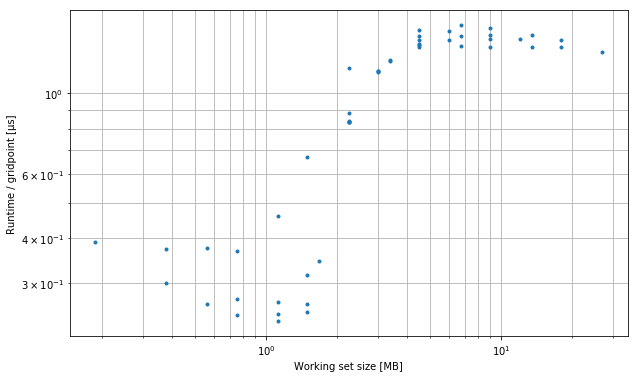

In [16]:
work_size = 4 * 3 * data[:, 1] * data[:, 2] * data[:, 3] # TODO
runtime_per_gridpoint = data[:, 5] / data[:, 1] / data[:, 2] / data[:, 3] # TODO
plt.loglog( work_size / 1024. / 1024., runtime_per_gridpoint * 1.0e6 , '.');
plt.xlabel( 'Working set size [MB]' );
plt.ylabel( 'Runtime / gridpoint [µs]' );
plt.grid(b=True, which='both')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

## Performance Analysis Tool (perftool-lite)

We can also use a performance analysis tool from Cray named <tt>perftools-lite</tt> to analyze the performance of our stencil program (see [this video](https://www.youtube.com/watch?v=FRi8uellZ18) for more information. In fact, our program has already been compiled for performance analysis with <tt>perftools-lite</tt> since we have loaded the corresponding module. <tt>stencil2d-counters.x+orig</tt> is the original executable without instrumentation for performance analysis and <tt>stencil2d-counters.x</tt> is an executable specifically prepared for performance analysis.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>9.</b> Run your program with counters <tt>perftools-lite</tt>. Read the report generated by <tt>perftools-lite</tt> carefully (written to the file <tt>report_counter_128x128x64.txt</tt>). What can you learn from the profiling?<br>
<b>10.</b> Compare the memory transfer numbers against your values. By which factor are you off? What could be the reason?<br>
<b>11.</b> Run again with $nx = 64$ and $ny = 32$. Did the factor by which you are off change? Is this consistent with the findings above? Do you have an idea why this might be the case?<br>
</div>

In [17]:
%%bash
echo "====== 128 x 128 x 64 ======"
srun -n 12 ./stencil2d-counters.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_counter_128x128x64.txt

====== 128 x 128 x 64 ======


CrayPat/X:  Version 7.1.1 Revision 7c0ddd79b  08/19/19 16:58:46


In [18]:
%%bash
echo "====== 64 x 32 x 64 ======"
srun -n 12 ./stencil2d-counters.x --nx 64 --ny 32 --nz 64 --num_iter 1024 > report_counter_64x32x64.txt

====== 64 x 32 x 64 ======


CrayPat/X:  Version 7.1.1 Revision 7c0ddd79b  08/19/19 16:58:46


*Solution:* <br>
Running at nx=128 ny=128 nz=65 and num_iter=1024 we have 255.2 GB from the counters and perftools-lite reports 141.14 GB, that's only 55% of our estimate from the counters.<br>
Running at nx=64 ny=32 nz=64 and num_iter=1024 we have 33.5 GB from the counters and perftools-lite reports 1.16 GB, that's only 3.5% of our estimate from the counters.<br>
The reason for the large discrepancy is that memory accesses are cached. We have 2.5 MB of L3 cache per core. A float32 field occupies 4 MB for <tt>nx x ny x nz</tt> = 128 x 128 x 64 and 0.5 MB for <tt>nx x ny x nz</tt> = 64 x 32 x 64. We have 3 fields in the code (<tt>in_field, tmp_field, out_field</tt>). In the first case we do not fit into L3 cache. In the second case, we easily fit into L3 cache and only have to read the fields once, after that they can be read from / written to in cache.

In [19]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
